In [1]:
!pip install transformers datasets evaluate -qq

In [2]:
from datasets import load_dataset, load_metric
from transformers import (
    RobertaTokenizerFast, BertTokenizerFast, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline
)
import torch
import numpy as np
import evaluate
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({'font.size': 16})

## Load Data

In [3]:
paws = load_dataset("paws", 'labeled_final')

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset paws downloaded and prepared to /root/.cache/huggingface/datasets/paws/labeled_final/1.1.0/8d567c6472623f42bd2cc635cad06932d0f0cd2f897db56013c1180f4317d338. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
paws

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
})

In [6]:
paws["train"][0]

{'id': 1,
 'sentence1': 'In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .',
 'sentence2': 'In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .',
 'label': 0}

In [52]:
pos_sample = paws["train"].filter(lambda ex: ex["label"] == 1)
neg_sample = paws["train"].filter(lambda ex: ex["label"] == 0)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [8]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

### Label Imbalance checking

Text(0, 0.5, 'count')

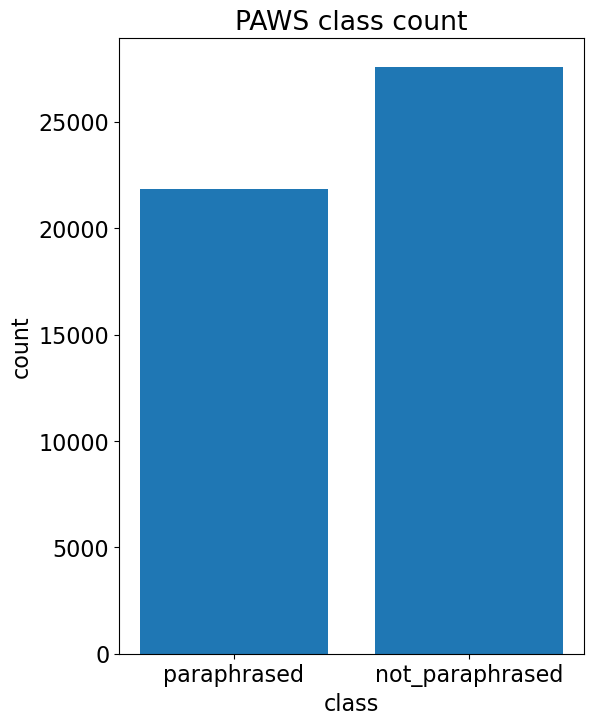

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))
labels = ["paraphrased", "not_paraphrased"]
count_ = [len(pos_sample), len(neg_sample)]
ax.bar(labels, count_)
ax.set_title("PAWS class count")
ax.set_xlabel("class")
ax.set_ylabel("count")

In [57]:
[len(pos_sample), len(neg_sample)]

[21829, 27572]

### Sentence length survey

In [54]:
sent1_len = [len(sent1.split()) for sent1 in paws["train"]["sentence1"]]
sent2_len = [len(sent2.split()) for sent2 in paws["train"]["sentence2"]]

In [55]:
np.mean(sent1_len), np.mean(sent2_len)

(21.340782575251513, 21.337948624521772)

Text(0, 0.5, 'mean length')

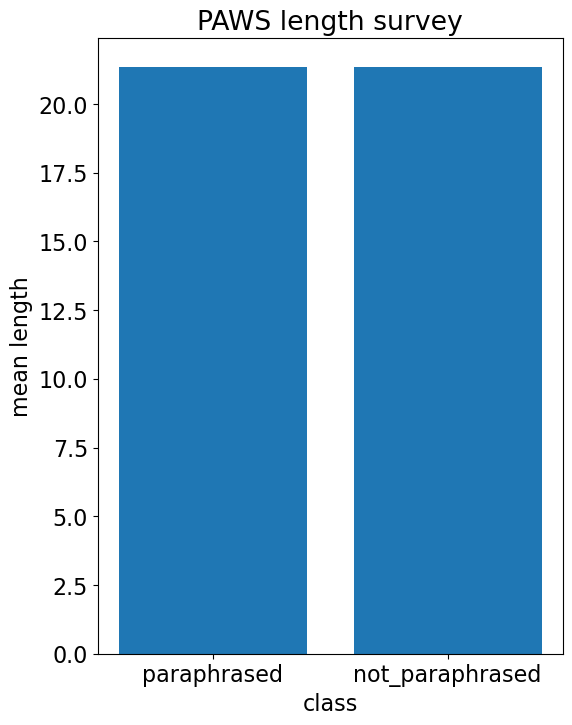

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))
labels = ["paraphrased", "not_paraphrased"]
mean_len = [np.mean(sent1_len),np.mean(sent2_len)]
ax.bar(labels, mean_len)
ax.set_title("PAWS length survey")
ax.set_xlabel("class")
ax.set_ylabel("mean length")

In [13]:
max(sent1_len)

37

In [7]:
id2label = {
    1: 'paraphrased', 
    0: 'not_paraphrased'
}
label2id = {
    'paraphrased': 1, 
    'not_paraphrased': 0
}

In [8]:
id2label, label2id

({1: 'paraphrased', 0: 'not_paraphrased'},
 {'paraphrased': 1, 'not_paraphrased': 0})

### Sample pairs are paraphrases

In [61]:
show_random_elements(pos_sample, num_examples=5)

,id,sentence1,sentence2,label
0,20445,"First Presbyterian Church is located in 1702 Iowa Street , Davenport , Iowa Davenport , Iowa , United States .","First Presbyterian Church is located at 1702 Iowa Street , Davenport , Iowa Davenport , Iowa , United States .",1
1,18125,"She is born on April 18 , 1976 in Usera , Spain ( Madrid ) .","She is born on 18 April 1976 in Usera , Madrid ( Spain ) .",1
2,16475,"As a child , Daily lost his right hand in a weapons accident , and Abbott was born without a left hand .","Daily lost his right hand in a gun accident as a child , and Abbott was born without a left hand .",1
3,10166,"When he succeeded Plettner in 1981 , Karlheinz Kaske became the first chairman of the supervisory board not to be a member of the Siemens family .","When he was succeeded by Plettner in 1981 , Karlheinz Kaske became the first chairman of the supervisory board not to be a member of the Siemens family .",1
4,7510,"The journey begins from Mumbai to Goa via Nashik , Ajanta Ellora Caves , Kolhapur , Sindhudurg and back .","The journey starts from Mumbai to Goa via Nashik , Ajanta Ellora Caves , Kolhapur , Sindhudurg and back again .",1


### Sample pairs have different semantic meaning



In [62]:
show_random_elements(neg_sample, num_examples=5)

,id,sentence1,sentence2,label
0,39720,"For a vertical edge , we want to interpolate in horizontal direction by using only the column that is centered at the pixel .","For a horizontal edge , we want to interpolate in vertical direction , using only the column centered on the pixel .",0
1,43490,The MSX2 series features a Yamaha V9938 - video chip that has a 9-bit RGB palette ( 512 colours ) and manages some extended graphic modes .,"The MSX2 series features a Yamaha V9938 video chip , which manages a 9-bit RGB palette ( 512 colors ) and has some extended graphic modes .",0
2,32010,"In one of his works ( epic poem on Nikola Jurišić ) , Skanderbeg was a subordinate subject .",In one of his works ( epic poem on Skanderbeg ) a subordinate theme was Nikola Jurišić .,0
3,5134,LEO XU Projects is a young and international art gallery based in Shanghai that exhibits contemporary artists .,LEO XU Projects is a contemporary art gallery based in Shanghai exhibiting young and international artists .,0
4,34595,The pterostigmata of the white males are almost immature .,The pterostigmata of immature males are almost white .,0


## Download model

In [68]:
model_checkpoint = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [69]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "not_paraphrased",
    "1": "paraphrased"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "not_paraphrased": 0,
    "paraphrased": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

## Tokenizing

In [22]:
# Tokenize the input text
def tokenize_function(example):
    tokens = tokenizer(
        example['sentence1'], 
        example['sentence2'], 
        truncation=True
    )
    tokens["labels"] = example["label"]
    return tokens

tokenized_dataset = paws.map(tokenize_function, batched=True)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [23]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
})

## Modeling

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [22]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "paraphrased",
    "1": "not_paraphrased"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "not_paraphrased": 1,
    "paraphrased": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [23]:
print("we are using",device)

we are using cuda:0


In [24]:
example = tokenized_dataset['train'][0]
print(example.keys())

dict_keys(['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'attention_mask', 'labels'])


In [25]:
example

{'id': 1,
 'sentence1': 'In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .',
 'sentence2': 'In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .',
 'label': 0,
 'input_ids': [0,
  1121,
  2201,
  2156,
  11,
  779,
  379,
  2466,
  2156,
  37,
  16340,
  1145,
  5,
  2370,
  6499,
  2156,
  13047,
  2032,
  9144,
  22351,
  261,
  2156,
  1996,
  123,
  13,
  10,
  12373,
  7,
  671,
  7,
  1156,
  149,
  3430,
  479,
  2,
  2,
  1121,
  779,
  379,
  2466,
  2156,
  37,
  16340,
  1145,
  19,
  5,
  2370,
  6499,
  2156,
  13047,
  2032,
  9144,
  22351,
  261,
  2156,
  11,
  2201,
  2156,
  8,
  553,
  123,
  13,
  10,
  12373,
  7,
  671,
  7,
  3430,
  149,
  1156,
  479,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [26]:
tokenizer.decode(example['input_ids'])

'<s>In Paris, in October 1560, he secretly met the English ambassador, Nicolas Throckmorton, asking him for a passport to return to England through Scotland.</s></s>In October 1560, he secretly met with the English ambassador, Nicolas Throckmorton, in Paris, and asked him for a passport to return to Scotland through England.</s>'

In [27]:
tokenized_dataset['train'].features

{'id': Value(dtype='int32', id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['0', '1'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Value(dtype='int64', id=None)}

In [27]:
# metric = evaluate.load("accuracy", "f1")
metric = evaluate.load("glue", "qqp")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [28]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    report_to="none"
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],    
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    
)

In [32]:
# Train the model
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.274800,0.254819,0.917750,0.905785
1000,0.233400,0.229491,0.928250,0.920278
1500,0.190300,0.214886,0.934125,0.925407
2000,0.150500,0.199125,0.942250,0.935385
2500,0.126400,0.221845,0.936000,0.930188
3000,0.057000,0.236446,0.939125,0.933678
3500,0.101800,0.233070,0.945000,0.938974
4000,0.077000,0.223547,0.946250,0.940476
4500,0.117500,0.230198,0.946500,0.940523


TrainOutput(global_step=4632, training_loss=0.18233439909207388, metrics={'train_runtime': 1536.7061, 'train_samples_per_second': 96.442, 'train_steps_per_second': 3.014, 'total_flos': 6123406202499600.0, 'train_loss': 0.18233439909207388, 'epoch': 3.0})

In [33]:
trainer.evaluate()

{'eval_loss': 0.23019804060459137,
 'eval_accuracy': 0.9465,
 'eval_f1': 0.9405225125069483,
 'eval_runtime': 22.366,
 'eval_samples_per_second': 357.686,
 'eval_steps_per_second': 22.355,
 'epoch': 3.0}

In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [67]:
model.push_to_hub("harouzie/roberta-base-paws")
tokenizer.push_to_hub("harouzie/roberta-base-paws")


CommitInfo(commit_url='https://huggingface.co/harouzie/bert-base-paws/commit/27b10af50607271062149dc2a1dec9aa176e0c90', commit_message='Upload tokenizer', commit_description='', oid='27b10af50607271062149dc2a1dec9aa176e0c90', pr_url=None, pr_revision=None, pr_num=None)

### building pipeline on our model

In [12]:
model_checkpoint = "harouzie/roberta-base-paws"
tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

In [19]:
classifier = pipeline(
    "text-classification", 
    model=model, 
    tokenizer=tokenizer, 
    device="cuda:0", 
    padding="max_length",
    batch_size=32, 
    truncation=True
)

In [15]:
sample_test = paws["test"][:10]
sample_sents = list(zip(sample_test["sentence1"], sample_test["sentence2"]))

In [16]:
sample_sents

[('This was a series of nested angular standards , so that measurements in azimuth and elevation could be done directly in polar coordinates relative to the ecliptic .',
  'This was a series of nested polar scales , so that measurements in azimuth and elevation could be performed directly in angular coordinates relative to the ecliptic .'),
 ('His father emigrated to Missouri in 1868 but returned when his wife became ill and before the rest of the family could also go to America .',
  'His father emigrated to America in 1868 , but returned when his wife became ill and before the rest of the family could go to Missouri .'),
 ('In January 2011 , the Deputy Secretary General of FIBA Asia , Hagop Khajirian , inspected the venue together with SBP - President Manuel V. Pangilinan .',
  'In January 2011 , FIBA Asia deputy secretary general Hagop Khajirian along with SBP president Manuel V. Pangilinan inspected the venue .'),
 ('Steiner argued that , in the right circumstances , the spiritual 

In [20]:
for pair in sample_sents: 
    print(classifier(pair))

{'label': 'not_paraphrased', 'score': 0.7156925797462463}
{'label': 'paraphrased', 'score': 0.6368539333343506}
{'label': 'paraphrased', 'score': 0.9348475933074951}
{'label': 'not_paraphrased', 'score': 0.98002028465271}
{'label': 'paraphrased', 'score': 0.97890305519104}
{'label': 'paraphrased', 'score': 0.8595173358917236}
{'label': 'paraphrased', 'score': 0.9037628769874573}
{'label': 'paraphrased', 'score': 0.7452078461647034}
{'label': 'not_paraphrased', 'score': 0.8226280212402344}
{'label': 'paraphrased', 'score': 0.8264788389205933}


In [17]:
sample_test["label"]

[0, 0, 1, 0, 0, 1, 0, 1, 0, 1]

In [ ]:
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

In [36]:
text = "I like you. I like you"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [44]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-2.4111,  2.5407]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [45]:
logits = outputs.logits
logits

tensor([[-2.4111,  2.5407]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [46]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1

In [49]:
probs

tensor([0.0823, 0.9269], grad_fn=<SigmoidBackward0>)

In [47]:
predictions

array([0., 1.])